In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 9)

In [2]:
import pqr

# Загрузка и предобработка данных

In [3]:
prices = pd.read_excel('factors/russia/monthlyprice.xlsx', index_col=0, parse_dates=True)
pe = pd.read_excel('factors/russia/PE.xlsx', index_col=0, parse_dates=True)
avg_volume = pd.read_excel('factors/russia/betafilter.xlsx', index_col=0, parse_dates=True)

index = pd.read_excel('factors/russia/imoex.xlsx', index_col=0, parse_dates=True)

In [4]:
prices = prices.replace(0, np.nan)
pe = pe.replace(0, np.nan)
avg_volume = avg_volume.replace(0, np.nan)
index = index.replace(0, np.nan)

# Строим фактор стоимости и бенчмарк

In [5]:
liquidity = pqr.Factor(avg_volume).look_back()
liquidity_filter = liquidity > 10_000_000

value = pqr.Factor(pe).look_back(3).hold(3).filter(liquidity_filter)

In [6]:
imoex = pqr.Benchmark('IMOEX').from_index(index['IMOEX'])

# Конструируем портфель из 50% лучших по фактору стоимости компаний

In [7]:
portfolio = pqr.Portfolio('quantile 0-0.5')

portfolio.pick_by_factor(value, (0, 1/2), better='less', method='quantile')
portfolio.weigh_equally()
portfolio.allocate(prices)

Portfolio('quantile 0-0.5')

Смотрим его доходность и базовые статистики.

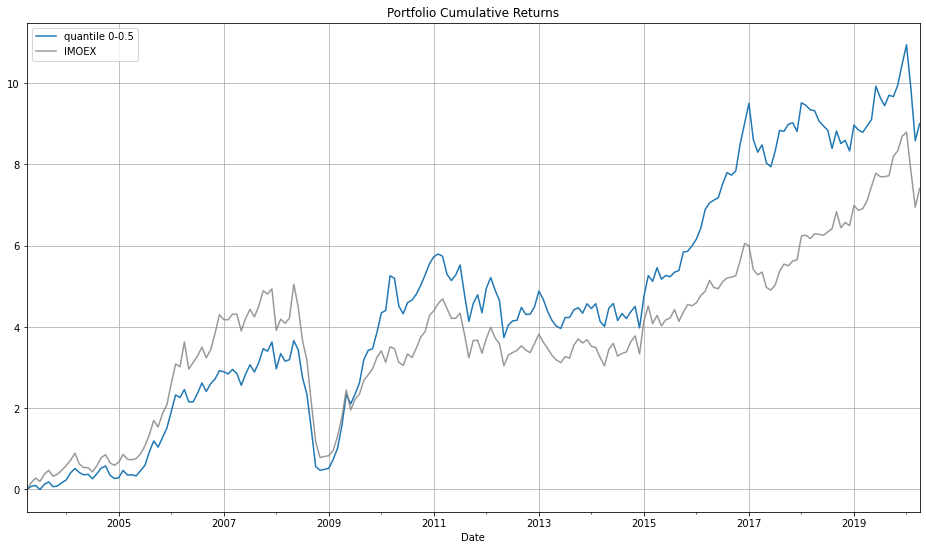

In [8]:
pqr.plot_cumulative_returns([portfolio], imoex)

In [9]:
pqr.summary(portfolio, imoex)

/home/akbabkin/programming/projects/pqr/venv/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/home/akbabkin/programming/projects/pqr/venv/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Total Return, %          900.45
Annual Return, %          14.43
Annual Volatility, %      27.04
Mean Return, %             1.44
Win Rate, %               60.98
Volatility, %              7.80
Maximum Drawdown, %      -68.43
VaR, %                   -10.68
Expected Tail Loss, %    -16.31
Rachev Ratio               1.12
Calmar Ratio               0.21
Sharpe Ratio               0.64
Omega Ratio                1.67
Sortino Ratio              1.00
Benchmark Correlation      0.91
Mean Excess Return, %      0.15
Excess Returns t-stat      0.68
Alpha, %                   0.16
Alpha t-stat               0.69
Beta                       1.00
Name: quantile 0-0.5, dtype: float64

# Пробуем поскейлить

Выглядит неплохо, но видно, что в периоды высокой волатильности (особенно 2008 г.) портфель проигрывает бенчмарку. Попробуем это исправить за счет скейлинга по волатильности.

In [10]:
# получаем среднемесячную волатильность (усредненную за год)
volatility = pqr.rolling_volatility(portfolio.returns, window=12)

Судя по графику, это действительно должно помочь.

<AxesSubplot:xlabel='Date'>

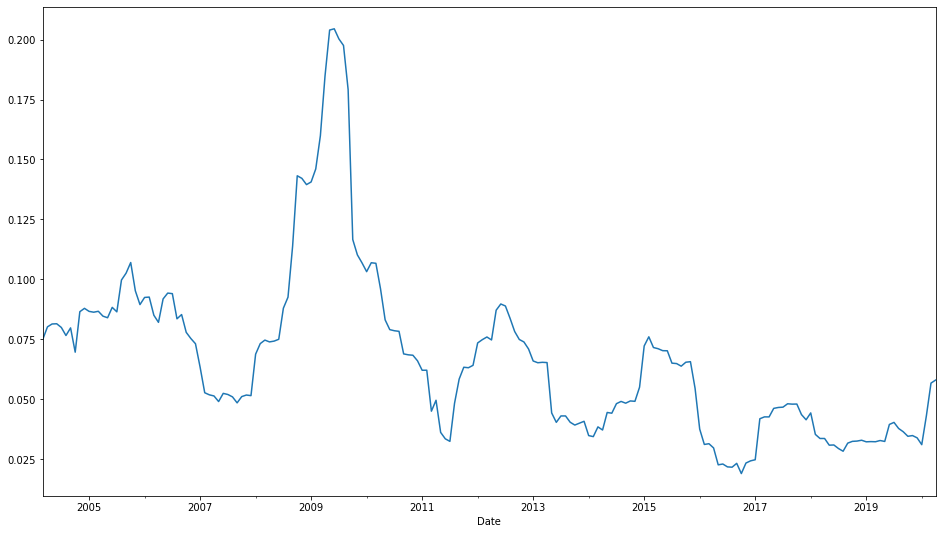

In [11]:
volatility.plot()

In [12]:
volatility_factor = pqr.Factor(volatility)

In [13]:
portfolio.scale_by_factor(volatility_factor, target=0.1, better='less')

Portfolio('quantile 0-0.5')

Посмотрим на получившееся плечо портфеля.

<AxesSubplot:xlabel='Date'>

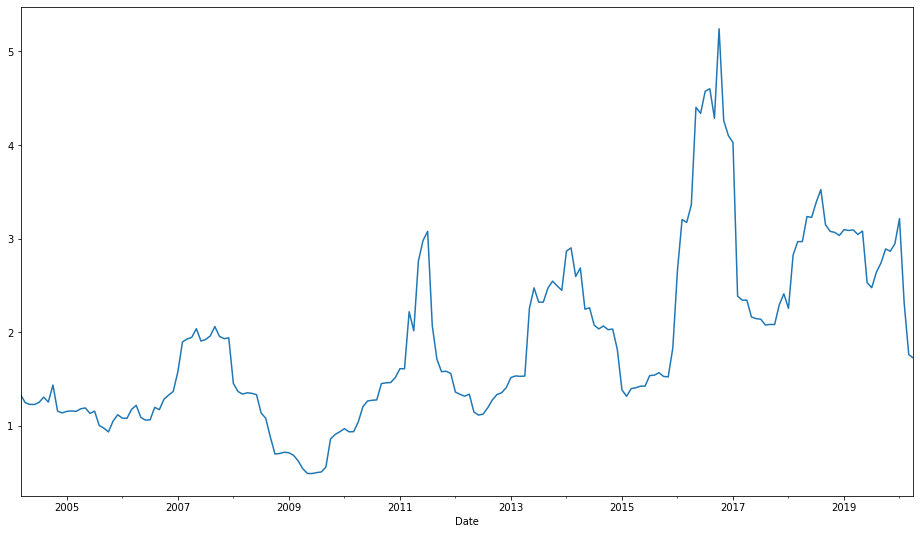

In [14]:
portfolio.weights.sum(axis=1).plot()

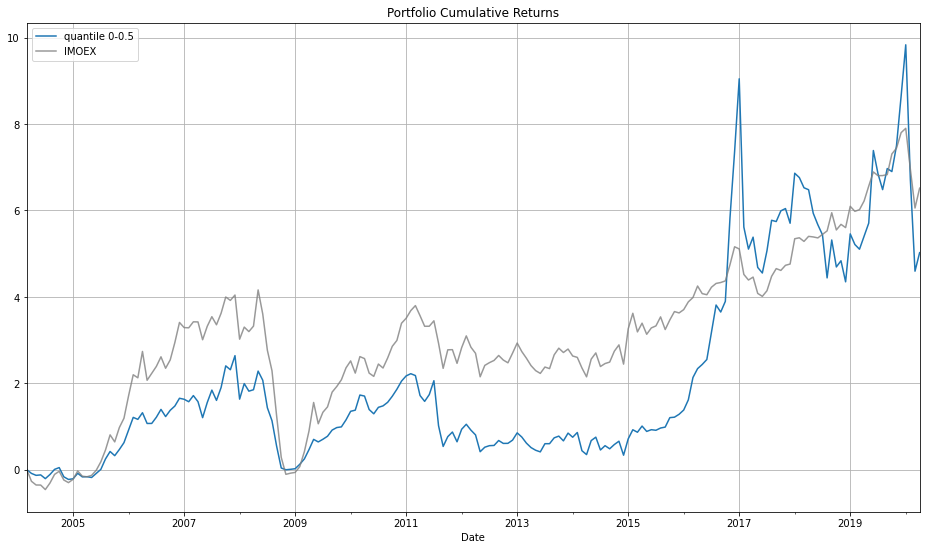

In [15]:
portfolio.allocate(prices)
pqr.plot_cumulative_returns([portfolio], imoex)

Стало хуже, потому что в 2008 году пришлось понижать плечо слишком поздно, за счет чего не был пойман отскок рынка (зато падение поймали отлично), а в 2017 году на экстремально низкой волатильности портфеля было повышено плечо очень сильно, что привело к большим потерям. Попробуем ограничить плечо.

In [16]:
portfolio.weigh_equally() # сбрасываем веса, чтобы не скейлить отскейленные :)
portfolio.scale_by_factor(volatility_factor, target=0.1, better='less', leverage_limits=(0, 2))

Portfolio('quantile 0-0.5')

Видно, что теперь плечо ограничено 2 сверху.

<AxesSubplot:xlabel='Date'>

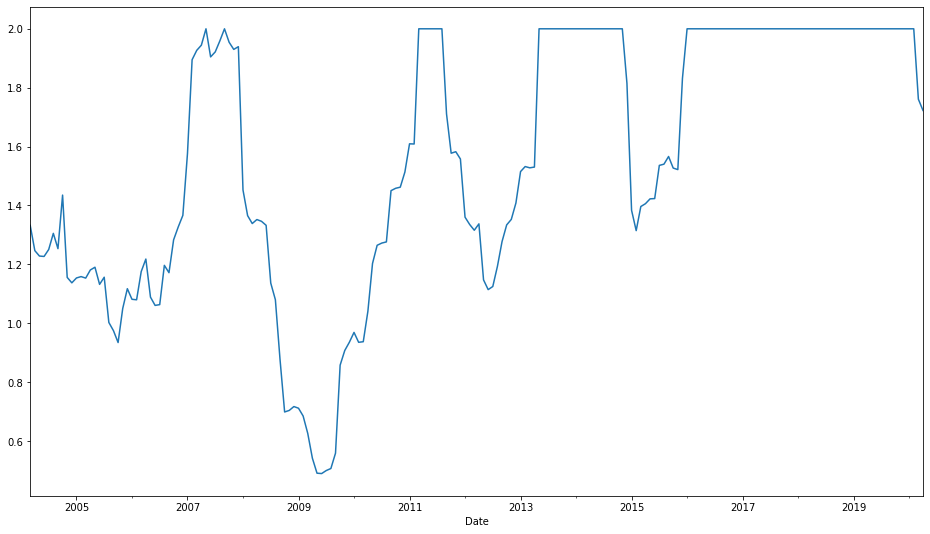

In [17]:
portfolio.weights.sum(axis=1).plot()

Но сильно лучше не стало: хотя в 2017 ушла такая бешеная волатильность портфеля, в 2008 оставание никуда не делось.

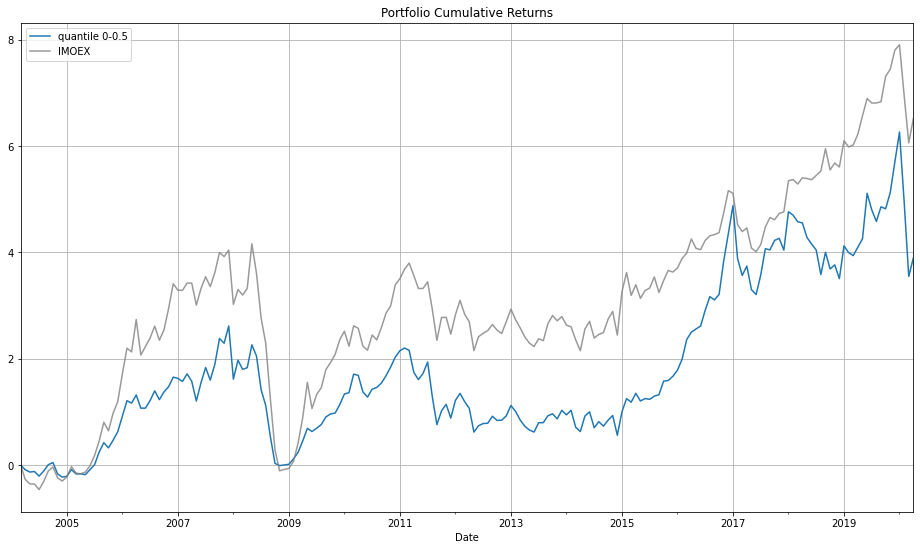

In [18]:
portfolio.allocate(prices)
pqr.plot_cumulative_returns([portfolio], imoex)